In [250]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import random
import collections
from matplotlib import colors

import mdptoolbox.mdp as mdp
import mdptoolbox.example
from hiive.mdptoolbox import mdp as hmdp

%config Completer.use_jedi = False

import warnings
warnings.filterwarnings('ignore')

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

## Helpers

In [812]:
def get_frozen_lake(name, is_random=False, p=0.82, random_seed=12345678, random_size=8):
    if is_random:
        np.random.seed(random_seed)
        flsz = random_size
        flrmap = generate_random_map(size=flsz, p=p)
        env = gym.make(name, desc=flrmap, is_slippery = True)
    else:
        env = gym.make(name)
    
#     nA, nS = env.nA, env.nS
#     P_fl = np.zeros([nA, nS, nS])
#     R_fl = np.zeros([nS, nA])
    
#     for s in range(nS):
#         for a in range(nA):
#             transitions = env.P[s][a]
#             for p_trans, next_s, reward, _ in transitions:
#                 P_fl[a,s,next_s] += p_trans
#                 R_fl[s,a] = reward
#             P_fl[a,s,:] /= np.sum(P_fl[a,s,:])
#     return env, P_fl, R_fl

    states = env.observation_space.n
    actions = env.action_space.n

    trans = np.zeros((actions, states, states))
    rewards = np.zeros((states, actions))

    for state in env.env.P:
        for action in env.env.P[state]:
            for opt in env.env.P[state][action]:
                trans[action][state][opt[1]] += opt[0]
                rewards[state][action] += opt[2]

    return env, trans, rewards

In [281]:
def render_frozen_lake(s, h, w):
    array = []
    for r in s:
        if r=='S':
            array.append(0)
        if r=='F':
            array.append(1)
        if r=='H':
            array.append(2)
        if r=='G':
            array.append(3)
            
    array = np.array(array).reshape(h, w)
    
    cmap = colors.ListedColormap(['yellow','lightskyblue','grey','greenyellow'])
    
    plt.imshow(array, interpolation='nearest', cmap=cmap)
    plt.tight_layout()
    plt.show()

In [444]:
def show_policy(vi, w, h, title, save_as):
    policy_array = np.array(list(vi.policy)).reshape(w,h).astype(str)
    value_array = np.round(np.array(list(vi.V)).reshape(w,h), 2)

    policy_array[policy_array=='0'] = '←'
    policy_array[policy_array=='1'] = '↓'
    policy_array[policy_array=='2'] = '→'
    policy_array[policy_array=='3'] = '↑'

    policy_array

    policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(policy_array.flatten(), value_array.flatten())])).reshape(w,h)
    plt.figure(figsize=(w,h))
    plt.title(title)
    sns.heatmap(value_array, annot=policy_viz, fmt="")
    plt.savefig(save_as)

##### Value Iteration Runner

In [448]:
def run_vi(P, R, gamma, epsilon, max_iter, verbose=False):    
    vi = hmdp.ValueIteration(
        transitions=P, 
        reward=R, 
        gamma=gamma,
        epsilon=epsilon,
        max_iter=max_iter,
    )
    
    st = time.time()
    # Run Value Iteration
    vi.run()
    et = time.time()

    if verbose:
        print("Policy: ", vi.policy)
        print("Iterations: ", vi.iter)
        print("CPU time: ", vi.time)
        print("Error mean: ", vi.error_mean)
        print("Wallclock time :", (et-st))
        print("------------------------------------------------------------------")
    
    return vi

##### Policy Iteration Runner

In [481]:
def run_pi(P, R, gamma, epsilon, max_iter, verbose=False):    
    pi = hmdp.PolicyIteration(
        transitions=P, 
        reward=R, 
        gamma=gamma,
#         epsilon=epsilon,
        max_iter=max_iter,
    )
    
    st = time.time()
    # Run Policy Iteration
    pi.run()
    et = time.time()

    if verbose:
        print("Policy: ", pi.policy)
        print("Iterations: ", pi.iter)
        print("CPU time: ", pi.time)
        print("Wallclock time :", (et-st))
        print("------------------------------------------------------------------")
    
    return pi

#### Q-learner Runner

In [997]:
def run_q(
    P, 
    R, 
    gamma=0.9999, 
    alpha=0.1, 
    alpha_decay=0.9999, 
    epsilon=0.1, 
    epsilon_decay=0.9999, 
    n_iter=10000, 
    verbose=False
):    

    ql = hmdp.QLearning(
        transitions=P, 
        reward=R, 
        gamma=gamma,
        alpha=alpha,
        alpha_decay=alpha_decay,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        n_iter=n_iter,
    )
    
    st = time.time()
    # Run Policy Iteration
    ql.run()
    et = time.time()

    if verbose:
        print("Policy: ", ql.policy)
        print("CPU time: ", ql.time)
        print("Wallclock time :", (et-st))
        print("------------------------------------------------------------------")
    
    return ql

In [386]:
def get_stats(vi):
    run_stats = vi.run_stats
    data = collections.defaultdict(list)
    
    for stats in run_stats:
        data['state'].append(stats['State'])
        data['action'].append(stats['Action'])
        data['reward'].append(stats['Reward'])
        data['error'].append(stats['Error'])
        data['time'].append(stats['Time'])
#         data['alpha'].append(stats['Alpha'])
#         data['epsilon'].append(stats['Epsilon'])
        data['max_v'].append(stats['Max V'])
        data['mean_v'].append(stats['Mean V'])
        data['iteration'].append(stats['Iteration'])
    stats_df = pd.DataFrame(data)
    return stats_df

In [894]:
def get_stats_q(vi):
    run_stats = vi.run_stats
    data = collections.defaultdict(list)
    
    for stats in run_stats:
        data['state'].append(stats['State'])
        data['action'].append(stats['Action'])
        data['reward'].append(stats['Reward'])
        data['error'].append(stats['Error'])
        data['time'].append(stats['Time'])
        data['alpha'].append(stats['Alpha'])
        data['epsilon'].append(stats['Epsilon'])
        data['max_v'].append(stats['Max V'])
        data['mean_v'].append(stats['Mean V'])
        data['iteration'].append(stats['Iteration'])
    stats_df = pd.DataFrame(data)
    return stats_df

##### Generate Worlds

- Generate the 4x4 standard small world

In [1086]:
# env, P, R = get_frozen_lake(name="FrozenLake-v0")

# R[14,1] = 0
# R[14,2] = 1
# R[15] = 1

# w=4
# h=4

- Generate the 8X8 standard world

In [1078]:
# env, P, R = get_frozen_lake(name="FrozenLake8x8-v0")

# R[55,0] = 0
# R[55,1] = 1
# R[62,1] = 0
# R[62,2] = 1
# R[63] = 1

# w=8
# h=8

- Generate a random 8x8 world

In [946]:
# env, P, R = get_frozen_lake(name="FrozenLake8x8-v0", is_random=True, p=0.78, random_seed=12345678, random_size=8)
# w=8
# h=8

- Generate a random 6x6 random world

In [1166]:
env, P, R = get_frozen_lake(name="FrozenLake8x8-v0", is_random=True, p=0.78, random_seed=12345678, random_size=6)
w=6
h=6

##### Visualize World

In [1167]:
env.render()


SFFFFF
FFHFFF
FFFFFF
HFHFHF
HFHFHF
HFFFFG


In [1168]:
s = """
SFFFFF
FFHFFF
FFFFFF
HFHFHF
HFHFHF
HFFFFG
"""

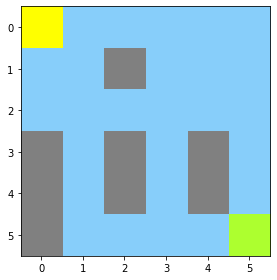

In [1169]:
render_frozen_lake(s=s, w=w, h=h)

# Value Iteration

### Tune Params

In [1170]:
vi_gamma_99 = run_vi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000)
vi_gamma_98 = run_vi(P=P, R=R, gamma=0.98, epsilon=0.01, max_iter=1000)
vi_gamma_97 = run_vi(P=P, R=R, gamma=0.97, epsilon=0.01, max_iter=1000)
vi_gamma_96 = run_vi(P=P, R=R, gamma=0.96, epsilon=0.01, max_iter=1000)

In [1171]:
df_gamma_99 = get_stats(vi_gamma_99)
df_gamma_98 = get_stats(vi_gamma_98)
df_gamma_97 = get_stats(vi_gamma_97)
df_gamma_96 = get_stats(vi_gamma_96)

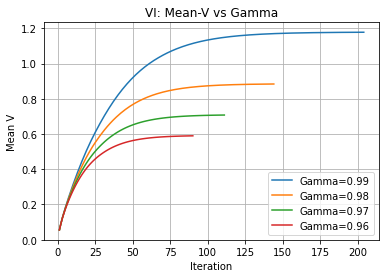

In [1173]:
plt.title("VI: Mean-V vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Mean V") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["mean_v"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["mean_v"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["mean_v"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["mean_v"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/vi_100.png")
plt.show()

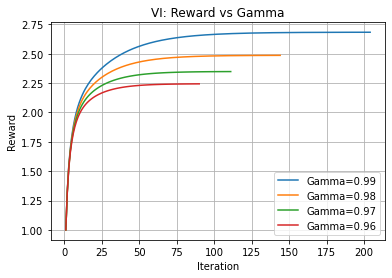

In [1174]:
plt.title("VI: Reward vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Reward") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["reward"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["reward"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["reward"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["reward"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/vi_101.png")
plt.show()

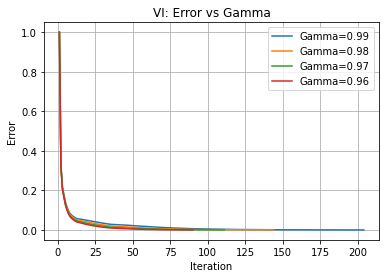

In [1175]:
plt.title("VI: Error vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Error") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["error"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["error"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["error"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["error"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/vi_102.png")
plt.show()

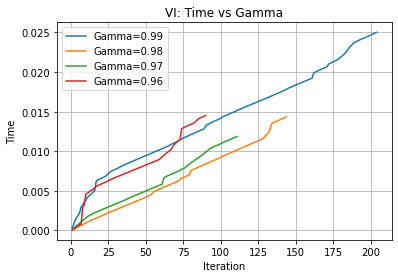

In [1176]:
plt.title("VI: Time vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Time") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["time"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["time"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["time"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["time"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/vi_103.png")
plt.show()

- Pick gamma=0.99

In [1177]:
vi_epsilon_1    = run_vi(P=P, R=R, gamma=0.99, epsilon=0.1, max_iter=1000)
vi_epsilon_01   = run_vi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000)
vi_epsilon_001  = run_vi(P=P, R=R, gamma=0.99, epsilon=0.001, max_iter=1000)

In [1178]:
df_epsilon_1    = get_stats(vi_epsilon_1)
df_epsilon_01   = get_stats(vi_epsilon_01)
df_epsilon_001  = get_stats(vi_epsilon_001)

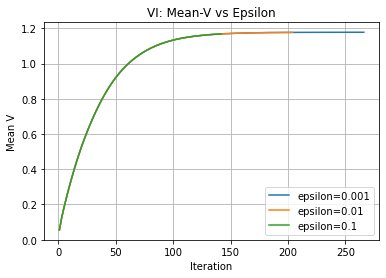

In [1179]:
plt.title("VI: Mean-V vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Mean V") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["mean_v"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["mean_v"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["mean_v"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.savefig("images/fl/vi_110.png")
plt.show()

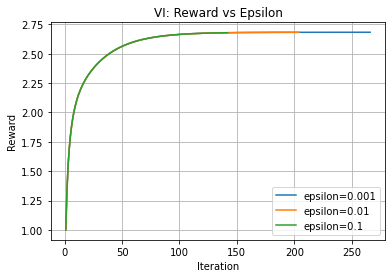

In [1180]:
plt.title("VI: Reward vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Reward") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["reward"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["reward"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["reward"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.savefig("images/fl/vi_111.png")
plt.show()

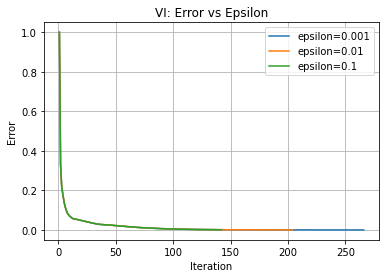

In [1181]:
plt.title("VI: Error vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Error") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["error"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["error"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["error"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.savefig("images/fl/vi_112.png")
plt.show()

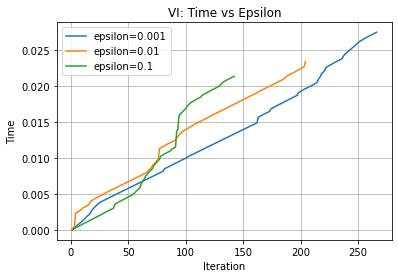

In [1182]:
plt.title("VI: Time vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Time") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["time"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["time"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["time"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.savefig("images/fl/vi_114.png")
plt.show()

- pick epsilon=0.01

In [1183]:
vi = run_vi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000, verbose=True)

Policy:  (3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 2, 2, 3, 3, 1, 3, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0)
Iterations:  204
CPU time:  0.03180217742919922
Error mean:  [0.043590009643766525, 0.0012160855362631118, 0.00010657495002641681]
Wallclock time : 0.03185391426086426
------------------------------------------------------------------


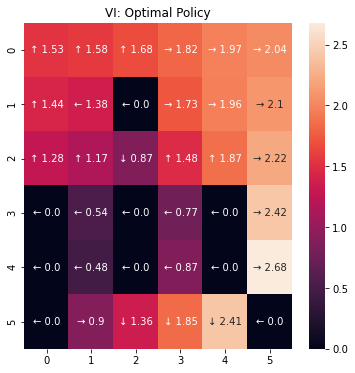

In [1184]:
show_policy(vi, w, h, "VI: Optimal Policy", save_as="images/fl/vi_120.png")

In [1187]:
vi.run_stats[150-1]

{'State': None,
 'Action': None,
 'Reward': 2.680173729574544,
 'Error': 0.0007511155262498459,
 'Time': 0.022574186325073242,
 'Max V': 2.680173729574544,
 'Mean V': 1.171429546623316,
 'Iteration': 150}

# Policy Iteration

- Tune gamma

In [1189]:
pi_gamma_99 = run_pi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=10)
pi_gamma_98 = run_pi(P=P, R=R, gamma=0.98, epsilon=0.01, max_iter=10)
pi_gamma_97 = run_pi(P=P, R=R, gamma=0.97, epsilon=0.01, max_iter=10)
pi_gamma_96 = run_pi(P=P, R=R, gamma=0.96, epsilon=0.01, max_iter=10)

In [1190]:
pi_gamma_99_df = get_stats(pi_gamma_99)
pi_gamma_98_df = get_stats(pi_gamma_98)
pi_gamma_97_df = get_stats(pi_gamma_97)
pi_gamma_96_df = get_stats(pi_gamma_96)

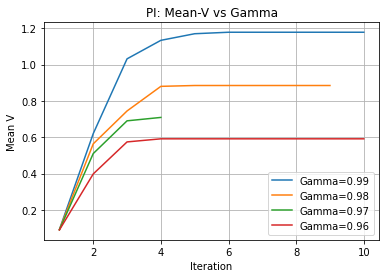

In [1191]:
plt.title("PI: Mean-V vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Mean V") 

plt.plot(pi_gamma_99_df["iteration"], pi_gamma_99_df["mean_v"], label="Gamma=0.99")
plt.plot(pi_gamma_98_df["iteration"], pi_gamma_98_df["mean_v"], label="Gamma=0.98")
plt.plot(pi_gamma_97_df["iteration"], pi_gamma_97_df["mean_v"], label="Gamma=0.97")
plt.plot(pi_gamma_96_df["iteration"], pi_gamma_96_df["mean_v"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/pi_100.png")
plt.show()

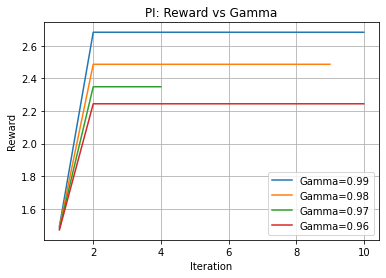

In [1192]:
plt.title("PI: Reward vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Reward") 

plt.plot(pi_gamma_99_df["iteration"], pi_gamma_99_df["reward"], label="Gamma=0.99")
plt.plot(pi_gamma_98_df["iteration"], pi_gamma_98_df["reward"], label="Gamma=0.98")
plt.plot(pi_gamma_97_df["iteration"], pi_gamma_97_df["reward"], label="Gamma=0.97")
plt.plot(pi_gamma_96_df["iteration"], pi_gamma_96_df["reward"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/pi_101.png")
plt.show()

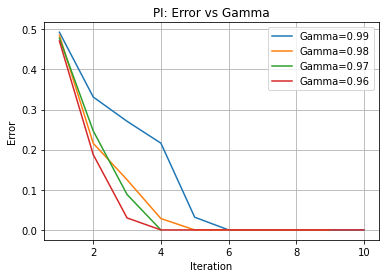

In [1193]:
plt.title("PI: Error vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Error") 

plt.plot(pi_gamma_99_df["iteration"], pi_gamma_99_df["error"], label="Gamma=0.99")
plt.plot(pi_gamma_98_df["iteration"], pi_gamma_98_df["error"], label="Gamma=0.98")
plt.plot(pi_gamma_97_df["iteration"], pi_gamma_97_df["error"], label="Gamma=0.97")
plt.plot(pi_gamma_96_df["iteration"], pi_gamma_96_df["error"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.savefig("images/fl/pi_102.png")
plt.show()

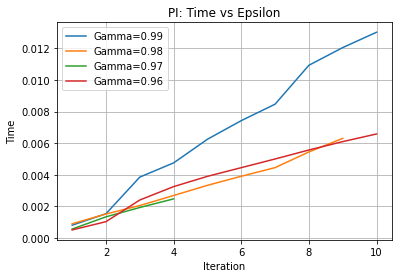

In [1194]:
plt.title("PI: Time vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Time") 


plt.plot(pi_gamma_99_df["iteration"], pi_gamma_99_df["time"], label="Gamma=0.99")
plt.plot(pi_gamma_98_df["iteration"], pi_gamma_98_df["time"], label="Gamma=0.98")
plt.plot(pi_gamma_97_df["iteration"], pi_gamma_97_df["time"], label="Gamma=0.97")
plt.plot(pi_gamma_96_df["iteration"], pi_gamma_96_df["time"], label="Gamma=0.96")


plt.grid()
plt.legend()
plt.savefig("images/fl/pi_114.png")
plt.show()

In [1195]:
pi = run_pi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=6, verbose=True)

Policy:  (3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0)
Iterations:  6
CPU time:  0.007791996002197266
Wallclock time : 0.00786590576171875
------------------------------------------------------------------


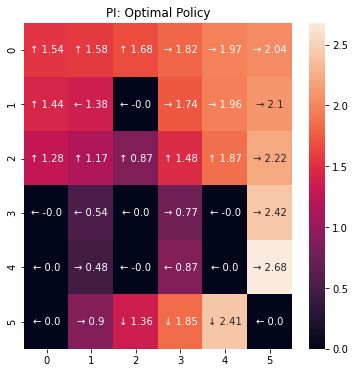

In [1196]:
show_policy(pi, w, h, "PI: Optimal Policy", save_as="images/fl/pi_120.png")

In [1199]:
pi.run_stats[6-1]

{'State': None,
 'Action': None,
 'Reward': 2.683015054783574,
 'Error': 1.4432899320127035e-15,
 'Time': 0.007745981216430664,
 'Max V': 2.683015054783574,
 'Mean V': 1.1784601836416357,
 'Iteration': 6}

# Q-Learning

In [1116]:
import random

np.random.seed(1234)
random.seed(1234)

### Tune Gamma

In [1117]:
ql_gamma_99 = run_q(P=P, R=R, gamma=0.99, n_iter=10**5)
ql_gamma_98 = run_q(P=P, R=R, gamma=0.98, n_iter=10**5)
ql_gamma_97 = run_q(P=P, R=R, gamma=0.97, n_iter=10**5)
ql_gamma_96 = run_q(P=P, R=R, gamma=0.96, n_iter=10**5)

In [1201]:
df_gamma_99 = get_stats_q(ql_gamma_99)
df_gamma_98 = get_stats_q(ql_gamma_98)
df_gamma_97 = get_stats_q(ql_gamma_97)
df_gamma_96 = get_stats_q(ql_gamma_96)

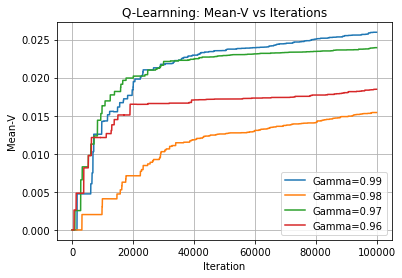

In [1202]:
plt.title("Q-Learnning: Mean-V vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_gamma_99["iteration"], df_gamma_99["mean_v"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["mean_v"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["mean_v"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["mean_v"], label="Gamma=0.96")


plt.grid()
plt.legend()
plt.savefig("images/fl/q_100.png")
plt.show()

- Gamma=0.99

#### Tune Alpha

In [1157]:
# ql_alpha_01 = run_q(P=P, R=R, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)
# ql_alpha_02 = run_q(P=P, R=R, gamma=0.99, alpha=0.2, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)
# ql_alpha_03 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)
# ql_alpha_04 = run_q(P=P, R=R, gamma=0.99, alpha=0.4, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)
# ql_alpha_05 = run_q(P=P, R=R, gamma=0.99, alpha=0.5, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)
ql_alpha_06 = run_q(P=P, R=R, gamma=0.99, alpha=0.6, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)
ql_alpha_07 = run_q(P=P, R=R, gamma=0.99, alpha=0.7, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)


In [1203]:
df_alpha_01 = get_stats_q(ql_alpha_01)
df_alpha_02 = get_stats_q(ql_alpha_02)
df_alpha_03 = get_stats_q(ql_alpha_03)
df_alpha_04 = get_stats_q(ql_alpha_04)
df_alpha_05 = get_stats_q(ql_alpha_05)
df_alpha_06 = get_stats_q(ql_alpha_06)
# df_alpha_07 = get_stats_q(ql_alpha_07)

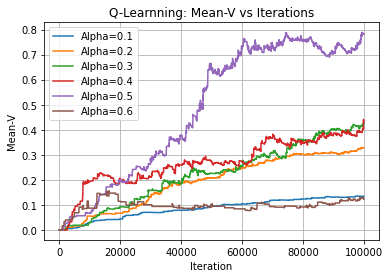

In [1204]:
plt.title("Q-Learnning: Mean-V vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_alpha_01["iteration"], df_alpha_01["mean_v"], label="Alpha=0.1")
plt.plot(df_alpha_02["iteration"], df_alpha_02["mean_v"], label="Alpha=0.2")
plt.plot(df_alpha_03["iteration"], df_alpha_03["mean_v"], label="Alpha=0.3")
plt.plot(df_alpha_04["iteration"], df_alpha_04["mean_v"], label="Alpha=0.4")
plt.plot(df_alpha_05["iteration"], df_alpha_05["mean_v"], label="Alpha=0.5")
plt.plot(df_alpha_06["iteration"], df_alpha_06["mean_v"], label="Alpha=0.6")
# plt.plot(df_alpha_07["iteration"], df_alpha_07["mean_v"], label="Alpha=0.7")


plt.grid()
plt.legend()
plt.savefig("images/fl/q_101.png")
plt.show()

- Alpha=0.3
- Gamma=0.99

### Tune alpha_decay

In [1127]:
ql_alpha_decay_99   = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99,  n_iter=10**5)
ql_alpha_decay_999  = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.999, n_iter=10**5)
ql_alpha_decay_9999 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.9999,n_iter=10**5)
ql_alpha_decay_99999 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999,n_iter=10**5)


In [1205]:
df_alpha_decay_99 = get_stats_q(ql_alpha_decay_99)
df_alpha_decay_999 = get_stats_q(ql_alpha_decay_999)
df_alpha_decay_9999 = get_stats_q(ql_alpha_decay_9999)
df_alpha_decay_99999 = get_stats_q(ql_alpha_decay_99999)

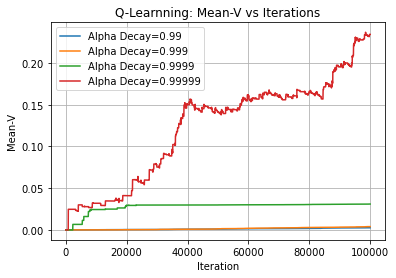

In [1206]:
plt.title("Q-Learnning: Mean-V vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_alpha_decay_99["iteration"], df_alpha_decay_99["mean_v"], label="Alpha Decay=0.99")
plt.plot(df_alpha_decay_999["iteration"], df_alpha_decay_999["mean_v"], label="Alpha Decay=0.999")
plt.plot(df_alpha_decay_9999["iteration"], df_alpha_decay_9999["mean_v"], label="Alpha Decay=0.9999")
plt.plot(df_alpha_decay_99999["iteration"], df_alpha_decay_99999["mean_v"], label="Alpha Decay=0.99999")


plt.grid()
plt.legend()
plt.savefig("images/fl/q_102.png")
plt.show()

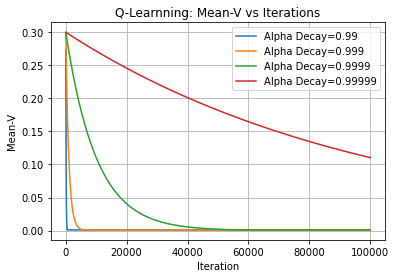

In [1207]:
plt.title("Q-Learnning: Mean-V vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_alpha_decay_99["iteration"], df_alpha_decay_99["alpha"], label="Alpha Decay=0.99")
plt.plot(df_alpha_decay_999["iteration"], df_alpha_decay_999["alpha"], label="Alpha Decay=0.999")
plt.plot(df_alpha_decay_9999["iteration"], df_alpha_decay_9999["alpha"], label="Alpha Decay=0.9999")
plt.plot(df_alpha_decay_99999["iteration"], df_alpha_decay_99999["alpha"], label="Alpha Decay=0.99999")


plt.grid()
plt.legend()
plt.savefig("images/fl/q_104.png")
plt.show()

### Tune Epsolon

In [1210]:
ql_epsilon_01 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=0.2, n_iter=10**5)
# ql_epsilon_05 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=0.5, n_iter=10**5)
# ql_epsilon_10 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=1.0, n_iter=10**5)


In [1211]:
df_epsilon_01 = get_stats_q(ql_alpha_epsilon_01)
df_epsilon_05 = get_stats_q(ql_alpha_epsilon_05)
df_epsilon_10 = get_stats_q(ql_alpha_epsilon_10)

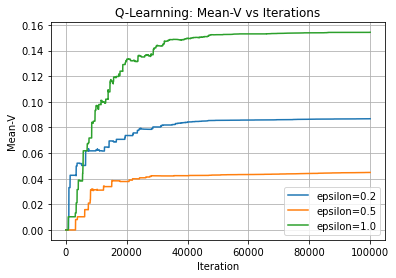

In [1212]:
plt.title("Q-Learnning: Mean-V vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_epsilon_01["iteration"], df_epsilon_01["mean_v"], label="epsilon=0.2")
plt.plot(df_epsilon_05["iteration"], df_epsilon_05["mean_v"], label="epsilon=0.5")
plt.plot(df_epsilon_10["iteration"], df_epsilon_10["mean_v"], label="epsilon=1.0")


plt.grid()
plt.legend()
plt.savefig("images/fl/q_105.png")
plt.show()

### Tune epsilon_decay

In [1137]:
ql_epsilon_decay_99   = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.99, n_iter=10**5)
ql_epsilon_decay_999  = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.999, n_iter=10**5)
ql_epsilon_decay_9999 = run_q(P=P, R=R, gamma=0.99, alpha=0.3, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**5)


In [1138]:
df_epsilon_decay_99   = get_stats_q(ql_epsilon_decay_99)
df_epsilon_decay_999  = get_stats_q(ql_epsilon_decay_999)
df_epsilon_decay_9999 = get_stats_q(ql_epsilon_decay_9999)

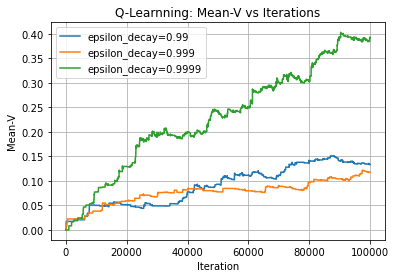

In [1209]:
plt.title("Q-Learnning: Mean-V vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_epsilon_decay_99["iteration"], df_epsilon_decay_99["mean_v"], label="epsilon_decay=0.99")
plt.plot(df_epsilon_decay_999["iteration"], df_epsilon_decay_999["mean_v"], label="epsilon_decay=0.999")
plt.plot(df_epsilon_decay_9999["iteration"], df_epsilon_decay_9999["mean_v"], label="epsilon_decay=0.9999")


plt.grid()
plt.legend()
plt.savefig("images/fl/q_106.png")
plt.show()

In [1213]:
ql = run_q(P=P, R=R, gamma=0.99, alpha=0.6, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=0.5*10**6, verbose=True)


Policy:  (3, 3, 3, 2, 2, 1, 3, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 2, 0, 0, 0, 3, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0)
CPU time:  45.68903207778931
Wallclock time : 45.6890389919281
------------------------------------------------------------------


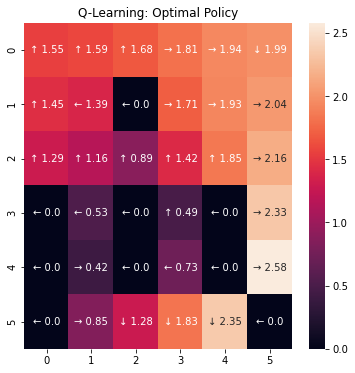

In [1214]:
show_policy(ql, w, h, "Q-Learning: Optimal Policy", save_as="images/fl/q_120.png")

In [1215]:
df_ql   = get_stats_q(ql)

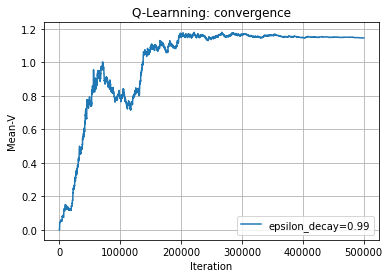

In [1216]:
plt.title("Q-Learnning: convergence")
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_ql["iteration"], df_ql["mean_v"], label="epsilon_decay=0.99")


plt.grid()
plt.legend()
# plt.savefig("images/fl/q_100.png")
plt.show()

In [1221]:
ql.run_stats[10000-1]

{'State': 28,
 'Action': 0,
 'Reward': 0.0,
 'Error': 0.0,
 'Time': 45.68876910209656,
 'Alpha': 0.0040427075580034815,
 'Epsilon': 0.1,
 'Gamma': 0.99,
 'Max V': 2.577060161408047,
 'Mean V': 1.1454147106207113,
 'Iteration': 500000}

## Large World
- For Comparison with 6x6 world

In [1235]:
env_sm, P_sm, R_sm = get_frozen_lake(name="FrozenLake8x8-v0")

w_sm=8
h_sm=8

In [1236]:
env_sm.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [1237]:
s_sm = """
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
"""

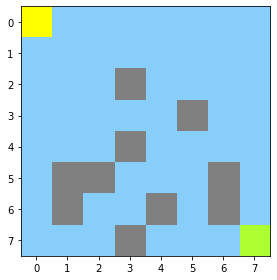

In [1238]:
render_frozen_lake(s=s_sm, w=w_sm, h=h_sm)

In [1239]:
vi_sm = run_vi(P=P_sm, R=R_sm, gamma=0.99, epsilon=0.01, max_iter=1000, verbose=True)

Policy:  (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 1, 0)
Iterations:  257
CPU time:  0.02855992317199707
Error mean:  [0.04267694083496466, 0.002564361936591847, 0.00026087783014753016]
Wallclock time : 0.028599977493286133
------------------------------------------------------------------


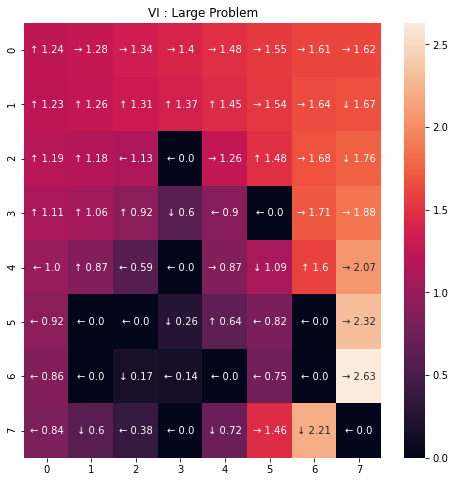

In [1245]:
show_policy(vi_sm, w_sm, h_sm, "VI : Large Problem", save_as="images/fl/sm_vi_100.png")

In [1241]:
df_vi_sm   = get_stats(vi_sm)

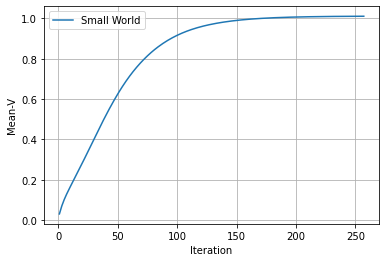

In [1242]:
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_vi_sm["iteration"], df_vi_sm["mean_v"], label="Small World")


plt.grid()
plt.legend()
# plt.savefig("images/fl/q_100.png")
plt.show()

In [1286]:
vi_sm.run_stats[257-1]

{'State': None,
 'Action': None,
 'Reward': 2.6331430577475796,
 'Error': 9.897443880935164e-05,
 'Time': 0.028512954711914062,
 'Max V': 2.6331430577475796,
 'Mean V': 1.0102403000322013,
 'Iteration': 257}

In [1255]:
pi_sm = run_pi(P=P_sm, R=R_sm, gamma=0.99, epsilon=0.01, max_iter=6, verbose=True)

Policy:  (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 3, 0, 2, 1, 3, 2, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 3, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0)
Iterations:  6
CPU time:  0.006562948226928711
Wallclock time : 0.0066831111907958984
------------------------------------------------------------------


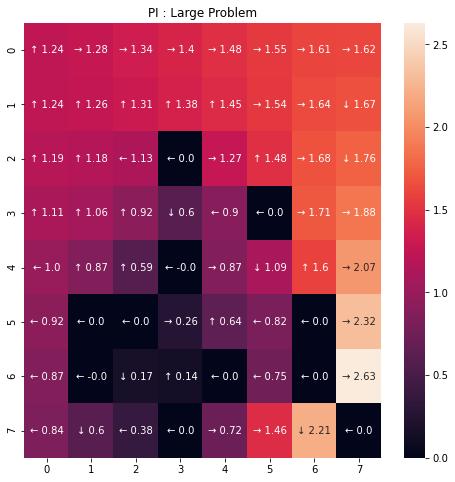

In [1256]:
show_policy(pi_sm, w_sm, h_sm, "PI : Large Problem", save_as="images/fl/sm_pi_100.png")

In [1257]:
df_pi_sm   = get_stats(pi_sm)

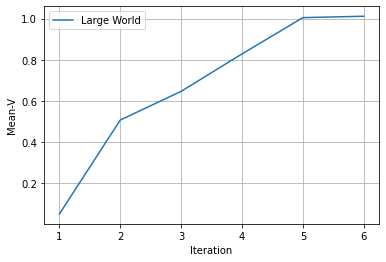

In [1258]:
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_pi_sm["iteration"], df_pi_sm["mean_v"], label="Large World")


plt.grid()
plt.legend()
# plt.savefig("images/fl/q_100.png")
plt.show()

In [1284]:
pi_sm.run_stats[5]

{'State': None,
 'Action': None,
 'Reward': 2.633306218197429,
 'Error': 5.551115123125783e-16,
 'Time': 0.006456136703491211,
 'Max V': 2.633306218197429,
 'Mean V': 1.011017715735763,
 'Iteration': 6}

In [1275]:
ql_sm = run_q(P=P_sm, R=R_sm, gamma=0.99, alpha=0.7, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.9999, n_iter=10**6, verbose=True)


Policy:  (3, 1, 3, 1, 2, 3, 2, 2, 2, 3, 2, 3, 2, 1, 2, 2, 0, 0, 0, 0, 2, 3, 2, 2, 2, 3, 0, 1, 0, 0, 2, 2, 0, 0, 3, 0, 2, 1, 3, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0)
CPU time:  77.18252229690552
Wallclock time : 77.18252921104431
------------------------------------------------------------------


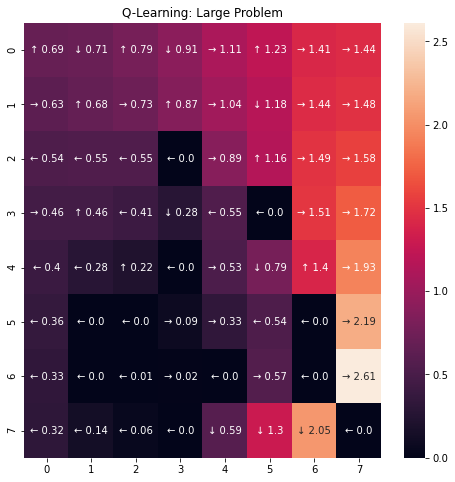

In [1276]:
show_policy(ql_sm, w_sm, h_sm, "Q-Learning: Large Problem", save_as="images/fl/sm_q_100.png")

In [1277]:
df_ql_sm   = get_stats(ql_sm)

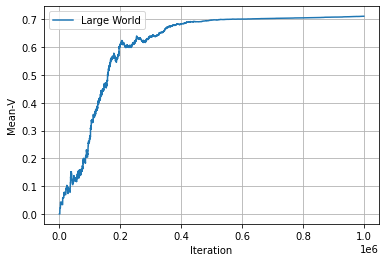

In [1278]:
plt.xlabel("Iteration")
plt.ylabel("Mean-V") 


plt.plot(df_ql_sm["iteration"], df_ql_sm["mean_v"], label="Large World")


plt.grid()
plt.legend()
# plt.savefig("images/fl/q_100.png")
plt.show()

In [1280]:
ql_sm.run_stats[10000-1]

{'State': 59,
 'Action': 0,
 'Reward': 0.0,
 'Error': 0.0,
 'Time': 77.18217921257019,
 'Alpha': 0.001,
 'Epsilon': 0.1,
 'Gamma': 0.99,
 'Max V': 2.607302247186841,
 'Mean V': 0.711529750824367,
 'Iteration': 1000000}